In [9]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

In [2]:
from utils import CommonFunctions_old as CF

In [6]:
def create_graph_comms(N, num_groups, mean_deg, k_out):
    nodes_per_group = N//num_groups; kave = mean_deg; k_out = .2#k_out = .15#kave is local average
    k_in = kave - k_out
    p_in = k_in/nodes_per_group
    p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
    print('Block model probs: in %f - out %f' % (p_in, p_out))

    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

    while nx.is_connected(G_gn) == 0:
        print('The network should be in a single component. New trial!')
        G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

    infoG_gn = ['GN',k_out]

    print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))
    
    return G_gn

In [7]:
N = 128
num_groups = 4
mean_deg = 16
k_out = .2

In [10]:
G_gn = create_graph_comms(N, num_groups, mean_deg, k_out)
A_gn = nx.to_numpy_array(G_gn)

#G_rand = nx.random_reference(G_gn, niter=1)
#A_rand = nx.to_numpy_array(G_rand)

Block model probs: in 0.493750 - out 0.002083
Mean degree 15.1875


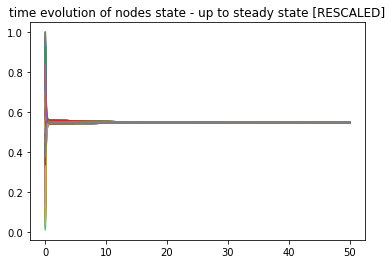

In [11]:
initial_state = np.random.random(N)
steady_state = CF.Numerical_Integration(A_gn, 'Synchronization', initial_state, show=True)

In [12]:
def Model_Synchronization(xx, t, G, fixed_node, w = 0., R = 1.):
    """
    m_0 = "w"; 
    m_1 = "R"; 
    m_2 = "sin(xx[j] - xx[i])"
    """    
    
    return w + R * np.sum(G*np.sin(xx - xx[:,None]), axis=1)

def Jacobian_Synchronization(G, xx, w = 0., R = 1.):
    num_nodes = G.shape[0]
    
    G[np.diag_indices_from(G)] = 0
    J = - R * np.sum(G*np.cos(xx - xx[:,None]), axis=1) * np.eye(num_nodes) + R * G*np.cos(xx - xx[:,None])
    
    return J

In [67]:
cs = ['purple', 'b', 'r', 'g']
comms = [np.zeros(N//num_groups)+c for c in range(num_groups)]
comms = np.concatenate(comms).astype('int')

In [78]:
def kuramoto(A, init=None, dt=0.001, T=int(1e3), w=0, R=1, show=False):
    N = A.shape[0]
    states = np.zeros((T,N))
    states[0] = np.random.random(N)

    for t in range(1,T):
        states[t] = states[t-1] + Model_Synchronization(states[t-1], [], A, [], w = 0., R = 1.) * dt
    
    if show:
        for i, tmp in enumerate(states.T):
            plt.plot(tmp, c=cs[comms[i]], alpha=0.9)
        plt.xlabel('t')
        plt.ylabel(r'$\theta_i$')
        plt.show()
        
    return states

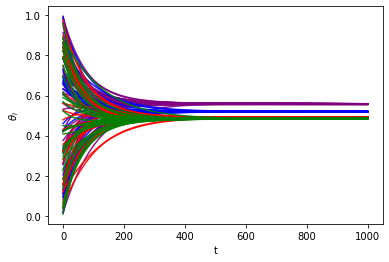

In [80]:
states = kuramoto(A_gn, show=True)

In [83]:
res = []

for _ in range(100):
    tmp = kuramoto(A_gn)
    res.append(tmp[-1])
    
res = np.array(res)

In [62]:
dt = 0.001
T = 1000

strength = 0.5
node_to_perturb = -1

pert = np.zeros((T,N))
pert[0] = states[-1]
pert[0,node_to_perturb] += strength

for t in range(1,T):
    pert[t] = pert[t-1] + Model_Synchronization(pert[t-1], [], A_gn, [], w = 0., R = 1.) * dt

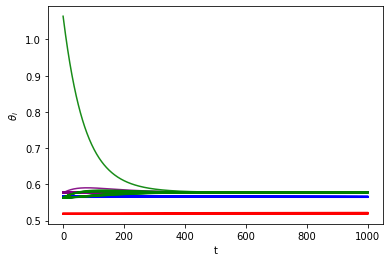

In [63]:
for i, tmp in enumerate(pert.T):
    plt.plot(tmp, c=cs[comms[i]], alpha=0.9)
    
plt.xlabel('t')
plt.ylabel(r'$\theta_i$')
plt.show()